### 1、数据准备

#### 1.1 前言
本项目是基于阿里天池杯利用panda解密美国选民的总体喜好的比赛，进行的相关的分析。同时，由于学习python的能力有限，对网上的许多代码进行了借鉴和修改，做成了本项目。
#### 1.2 数据集来源介绍
**所有候选人信息** 
</br>该文件为每个候选人提供一份记录，并显示候选人的信息、总收入、从授权委员会收到的转账、付款总额、给授权委员会的转账、库存现金总额、贷款和债务以及其他财务汇总信息。
</br>数据字段描述详细:https://www.fec.gov/campaign-finance-data/all-candidates-file-description/
</br>关键字段说明
- CAND_ID 候选人ID
- CAND_NAME 候选人姓名
- CAND_PTY_AFFILIATION 候选人党派



**候选人委员会链接信息** 
</br>该文件显示候选人的身份证号码、候选人的选举年份、联邦选举委员会选举年份、委员会识别号、委员会类型、委员会名称和链接标识号。
</br>信息描述详细:https://www.fec.gov/campaign-finance-data/candidate-committee-linkage-file-description/
</br>关键字段说明
- CAND_ID 候选人ID
- CAND_ELECTION_YR 候选人选举年份
- CMTE_ID 委员会ID



**个人捐款档案信息** 
【注意】由于文件较大，本数据集只包含2020.7.22-2020.8.20的相关数据，如果需要更全数据可以通过数据来源中的地址下载。
</br>该文件包含有关收到捐款的委员会、披露捐款的报告、提供捐款的个人、捐款日期、金额和有关捐款的其他信息。
</br>信息描述详细:[https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/](https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/)
</br>关键字段说明
- CMTE_ID  委员会ID
- NAME 捐款人姓名
- CITY 捐款人所在市
- State 捐款人所在州
- EMPLOYER 捐款人雇主/公司
- OCCUPATION 捐款人职业



#### 1.3 需要提前安装的包和导入的包

In [2]:
# 安装功能包
!pip install wordcloud --user
!pip install plotnine  --user
!wget https://img.alicdn.com/tfs/TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
--2021-01-17 15:06:30--  https://img.alicdn.com/tfs/TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg
Resolving img.alicdn.com (img.alicdn.com)... 101.227.24.251, 101.227.24.252
Connecting to img.alicdn.com (img.alicdn.com)|101.227.24.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4236 (4.1K) [image/jpeg]
Saving to: ‘TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg’

100%[======================================>] 4,236       --.-K/s   in 0s      

2021-01-17 15:06:30 (20.0 MB/s) - ‘TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg’ saved [4236/4236]



In [3]:
# 导入相关处理包
import pandas as pd
# 导入matplotlib中的pyplot
import matplotlib.pyplot as plt
# 为了使matplotlib图形能够内联显示
%matplotlib inline
# 导入词云库
from wordcloud import WordCloud,ImageColorGenerator
import seaborn as sns
import numpy as np
from plotnine import *
import os
from pyecharts.datasets import register_url
from pyecharts.charts import Geo
from pyecharts.globals import ChartType
from pyecharts import options as opts

#### 1.4 下载数据集
在项目开始前，先将数据集下载到项目中，便于后续对数据集的分析与处理。
其基本数据集如上图介绍所示，分为三个文件，分别是weball20.txt(所有获选人信息)、ccl.txt(候选人委员会链接信息)、itcont_2020_20200722_20200820.txt（2020年7月22日到8月20日的捐款信息）
其原始数据格式如下
</br>weball20.txt(所有获选人信息)
</br>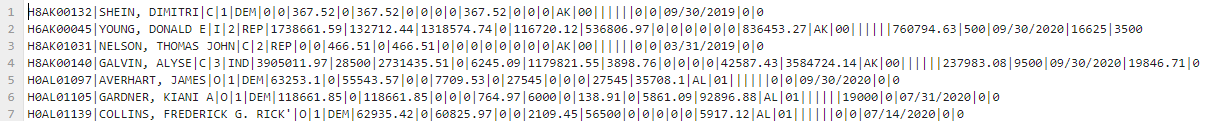
</br>ccl.txt(候选人委员会链接信息)
</br>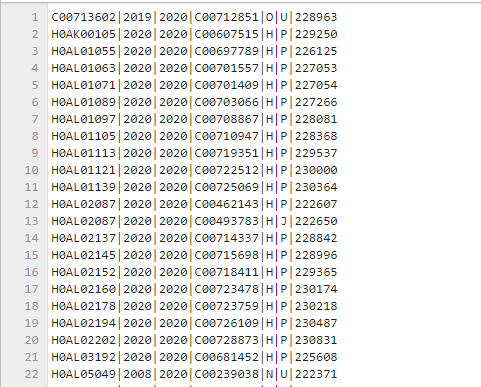
</br>itcont_2020_20200722_20200820.txt（2020年7月22日到8月20日的捐款信息）
</br>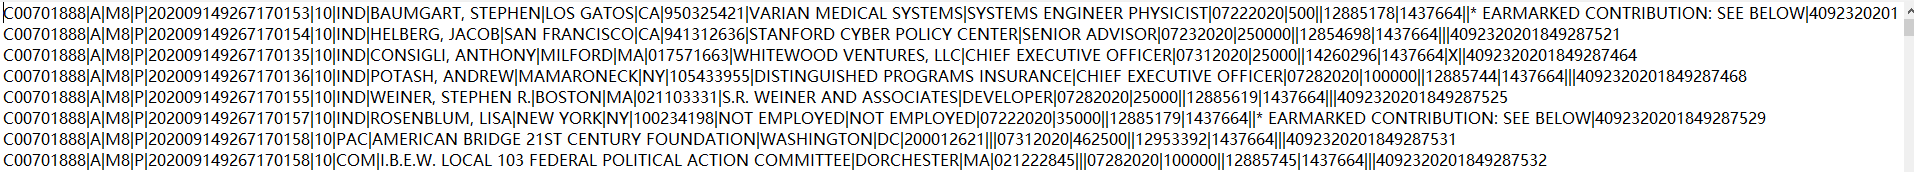

### 2、数据处理
我们对三个数据集的数据根据我们的需要进行关联，在此基础上进行相关分分析

#### 2.1 将委员会和候选人一一对应，通过`CAND_ID`关联两个表
由于候选人和委员会的联系表中无候选人姓名，只有候选人ID（`CAND_ID`），所以需要通过`CAND_ID`从候选人表中获取到候选人姓名，最终得到候选人与委员会联系表`ccl`。

In [4]:
# 读取候选人信息，由于原始数据没有表头，需要添加表头
candidates = pd.read_csv("weball20.txt", sep = '|',names=['CAND_ID','CAND_NAME','CAND_ICI','PTY_CD','CAND_PTY_AFFILIATION','TTL_RECEIPTS',
                                                          'TRANS_FROM_AUTH','TTL_DISB','TRANS_TO_AUTH','COH_BOP','COH_COP','CAND_CONTRIB',
                                                          'CAND_LOANS','OTHER_LOANS','CAND_LOAN_REPAY','OTHER_LOAN_REPAY','DEBTS_OWED_BY',
                                                          'TTL_INDIV_CONTRIB','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT','SPEC_ELECTION','PRIM_ELECTION','RUN_ELECTION'
                                                          ,'GEN_ELECTION','GEN_ELECTION_PRECENT','OTHER_POL_CMTE_CONTRIB','POL_PTY_CONTRIB',
                                                          'CVG_END_DT','INDIV_REFUNDS','CMTE_REFUNDS'])
# 读取候选人和委员会的联系信息
ccl = pd.read_csv("ccl.txt", sep = '|',names=['CAND_ID','CAND_ELECTION_YR','FEC_ELECTION_YR','CMTE_ID','CMTE_TP','CMTE_DSGN','LINKAGE_ID'])

In [5]:
# 关联两个表数据
ccl = pd.merge(ccl,candidates)
# 提取出所需要的列
ccl = pd.DataFrame(ccl, columns=[ 'CMTE_ID','CAND_ID', 'CAND_NAME','CAND_PTY_AFFILIATION'])

数据字段说明：
- CMTE_ID：委员会ID
- CAND_ID：候选人ID
- CAND_NAME：候选人姓名
- CAND_PTY_AFFILIATION：候选人党派

In [6]:
# 查看目前ccl数据前20行
ccl.head(20)

,CMTE_ID,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION
0,C00697789,H0AL01055,"CARL, JERRY LEE, JR",REP
1,C00701557,H0AL01063,"LAMBERT, DOUGLAS WESTLEY III",REP
2,C00701409,H0AL01071,"PRINGLE, CHRISTOPHER PAUL",REP
3,C00703066,H0AL01089,"HIGHTOWER, BILL",REP
4,C00708867,H0AL01097,"AVERHART, JAMES",DEM
5,C00710947,H0AL01105,"GARDNER, KIANI A",DEM
6,C00722512,H0AL01121,"CASTORANI, JOHN",REP
7,C00725069,H0AL01139,"COLLINS, FREDERICK G. RICK'",DEM
8,C00462143,H0AL02087,"ROBY, MARTHA",REP
9,C00493783,H0AL02087,"ROBY, MARTHA",REP


#### 2.2 将候选人和捐赠人一一对应，通过`CMTE_ID`关联两个表
通过`CMTE_ID`将目前处理好的候选人和委员会关系表与人捐款档案表进行关联，得到候选人与捐赠人一一对应联系表`cil`。

In [8]:
# 读取个人捐赠数据，由于原始数据没有表头，需要添加表头
# 提示：读取本文件大概需要5-10s
itcont = pd.read_csv('itcont_2020_20200722_20200820.txt', sep='|',names=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI',
                                                                                  'IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY',
                                                                                  'STATE','ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT',
                                                                                  'TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
                                                                                  'MEMO_TEXT','SUB_ID'])

In [9]:
# 将候选人与委员会关系表ccl和个人捐赠数据表itcont合并，通过 CMTE_ID
c_itcont =  pd.merge(ccl,itcont)
# 提取需要的数据列
c_itcont = pd.DataFrame(c_itcont, columns=[ 'CAND_NAME','NAME', 'STATE','EMPLOYER','OCCUPATION',
                                           'TRANSACTION_AMT', 'TRANSACTION_DT','CAND_PTY_AFFILIATION'])

**数据说明**
- CAND_NAME – 接受捐赠的候选人姓名
- NAME – 捐赠人姓名
- STATE – 捐赠人所在州
- EMPLOYER – 捐赠人所在公司
- OCCUPATION – 捐赠人职业
- TRANSACTION_AMT – 捐赠数额（美元）
- TRANSACTION_DT – 收到捐款的日期
- CAND_PTY_AFFILIATION – 候选人党派

In [10]:
# 查看目前数据前10行
c_itcont.head(10)

,CAND_NAME,NAME,STATE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,TRANSACTION_DT,CAND_PTY_AFFILIATION
0,"MORGAN, JOSEPH DAVID","MARTIN, WILLIAM II",AZ,RETIRED,RETIRED,100,7242020,REP
1,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,7242020,REP
2,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,7312020,REP
3,"WOOD, DANIEL","HOPKINS, RICHARD",AZ,POWERS-LEAVITT,INSURANCE AGENT,300,8102020,REP
4,"WOOD, DANIEL","PENDLETON, DIANE",AZ,UNEMPLOYED,NaN,500,8072020,REP
5,"WOOD, DANIEL","PREVATT, WILLIAM",AZ,SELF-EMPLOYED,DVM,500,7312020,REP
6,"WOOD, DANIEL","HARDING, DOUG",AZ,MICROSURE,OPERATIONS MANAGER,2800,8102020,REP
7,"WOOD, DANIEL","HARDING, MARI",AZ,NaN,NaN,1400,8152020,REP
8,"WOOD, DANIEL","HEDGER, CYNTHIA",TX,NaN,NaN,200,7312020,REP
9,"HUANG, PEGGY","HUANG - PERSONAL FUNDS, PEGGY",CA,OFFICE OF THE ATTORNEY GENERAL,DEPUTY ATTORNEY GENERAL,2600,7252020,REP


### 3、数据探索与清洗

进过数据处理部分，我们获得了可用的数据集，现在我们可以利用调用`shape`属性查看数据的规模，调用`info`函数查看数据信息，调用`describe`函数查看数据分布。

In [11]:
# 查看数据规模 多少行 多少列
c_itcont.shape

(756205, 8)

In [12]:
# 查看整体数据信息，包括每个字段的名称、非空数量、字段的数据类型
c_itcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756205 entries, 0 to 756204
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CAND_NAME             756205 non-null  object
 1   NAME                  756205 non-null  object
 2   STATE                 756160 non-null  object
 3   EMPLOYER              737413 non-null  object
 4   OCCUPATION            741294 non-null  object
 5   TRANSACTION_AMT       756205 non-null  int64 
 6   TRANSACTION_DT        756205 non-null  int64 
 7   CAND_PTY_AFFILIATION  756205 non-null  object
dtypes: int64(2), object(6)
memory usage: 51.9+ MB


通过上面的探索我们知道目前数据集的一些基本情况，目前数据总共有756205行，8列，总占用内存51.9+MB，`STATE`、`EMPLOYER`、`OCCUPATION`有缺失值，另外日期列目前为int64类型，需要进行转换为str类型。

In [13]:
#空值处理，统一填充 NOT PROVIDED
c_itcont['STATE'].fillna('NOT PROVIDED',inplace=True)
c_itcont['EMPLOYER'].fillna('NOT PROVIDED',inplace=True)
c_itcont['OCCUPATION'].fillna('NOT PROVIDED',inplace=True)

In [14]:
# 对日期TRANSACTION_DT列进行处理
c_itcont['TRANSACTION_DT'] = c_itcont['TRANSACTION_DT'] .astype(str)
# 将日期格式改为年月日  2020724	
c_itcont['TRANSACTION_DT'] = [i[3:7]+i[0]+i[1:3] for i in c_itcont['TRANSACTION_DT'] ]

In [15]:
# 再次查看数据信息
c_itcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756205 entries, 0 to 756204
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CAND_NAME             756205 non-null  object
 1   NAME                  756205 non-null  object
 2   STATE                 756205 non-null  object
 3   EMPLOYER              756205 non-null  object
 4   OCCUPATION            756205 non-null  object
 5   TRANSACTION_AMT       756205 non-null  int64 
 6   TRANSACTION_DT        756205 non-null  object
 7   CAND_PTY_AFFILIATION  756205 non-null  object
dtypes: int64(1), object(7)
memory usage: 51.9+ MB


In [16]:
# 查看数据前3行
c_itcont.head(3)

,CAND_NAME,NAME,STATE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,TRANSACTION_DT,CAND_PTY_AFFILIATION
0,"MORGAN, JOSEPH DAVID","MARTIN, WILLIAM II",AZ,RETIRED,RETIRED,100,2020724,REP
1,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,2020724,REP
2,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,2020731,REP


### 4、数据分析

In [17]:
# 查看候选人信息
c_itcont['CAND_NAME'].describe()

count                 756205
unique                   312
top       BIDEN, JOSEPH R JR
freq                  507816
Name: CAND_NAME, dtype: object

In [18]:
#显示一共有312名候选人获得捐款，其中拜登的次数最多

In [19]:
# 计算获得捐款前10的党
c_itcont.groupby("CAND_PTY_AFFILIATION").sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)

,TRANSACTION_AMT
CAND_PTY_AFFILIATION,
DEM,75961730
REP,37170653
IND,328802
LIB,169202
DFL,76825
GRE,18607
NON,11256
UNK,10195
CON,4117


In [20]:
# 计算获得捐款总额前十的候选人
c_itcont.groupby("CAND_NAME").sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)

,TRANSACTION_AMT
CAND_NAME,
"BIDEN, JOSEPH R JR",68111142
"TRUMP, DONALD J.",16594982
"SULLIVAN, DAN",9912465
"JACOBS, CHRISTOPHER L.",6939209
"BLOOMBERG, MICHAEL R.",3451916
"MARKEY, EDWARD J. SEN.",606832
"SHAHEEN, JEANNE",505446
"KENNEDY, JOSEPH P III",467738
"CORNYN, JOHN SEN",345959


获得捐赠最多的党派有`DEM(民主党)`、`REP(共和党)`，分别对应`BIDEN, JOSEPH R JR(拜登)`和`TRUMP, DONALD J.(特朗普)`，从我们目前分析的2020.7.22-2020.8.20这一个月的数据来看，在选民的捐赠数据中拜登代表的民主党完胜特朗普代表的共和党，由于完整数据量过大，所以没有对所有数据进行汇总分析，因此也不能确定11月大选公布结果就一定是拜登当选

In [21]:
# 查看不同职业的人捐款的总额，然后排序，取前十位
c_itcont.groupby('OCCUPATION').sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)

,TRANSACTION_AMT
OCCUPATION,
NOT EMPLOYED,24436214
RETIRED,18669950
NOT PROVIDED,5089355
ATTORNEY,4443569
FOUNDER,3519109
PHYSICIAN,3295595
CONSULTANT,1647033
LAWYER,1565976
PROFESSOR,1481260


In [22]:
# 查看不同公司的人捐款的总额，然后排序，取前十位
c_itcont.groupby('EMPLOYER').sum().sort_values("TRANSACTION_AMT",ascending=False).head(20)

,TRANSACTION_AMT
EMPLOYER,
NOT EMPLOYED,24912962
RETIRED,18332575
SELF-EMPLOYED,8262780
NOT PROVIDED,5542113
BLOOMBERG INC.,3451795
SELF EMPLOYED,995989
SELF,753450
HOMEMAKER,732772
ENTREPRENEUR,436984


In [23]:
# 查看每个职业捐款人的数量
c_itcont['OCCUPATION'].value_counts().head(10)

NOT EMPLOYED    224109
RETIRED         151834
ATTORNEY         19666
NOT PROVIDED     14912
PHYSICIAN        14033
CONSULTANT        8333
PROFESSOR         8022
TEACHER           8013
ENGINEER          7922
SALES             6435
Name: OCCUPATION, dtype: int64

从捐款人的职业这个角度分析，我们会发现`NOT EMPLOYED(自由职业)`的总捐赠额是最多，通过查看每个职业捐赠的人数来看，我们就会发现是因为`NOT EMPLOYED(自由职业)`人数多的原因，另外退休人员捐款人数也特别多，所以捐款总数对应的也多，其他比如像：律师、创始人、医生、顾问、教授、主管这些高薪人才虽然捐款总人数少，但是捐款总金额也占据了很大比例。在捐款职业方面，我们发现，facebook和Amazon、google这些公司捐款总额也名列前茅。

In [24]:
# 每个州获捐款的总额，然后排序，取前五位
c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False).head(5)

,TRANSACTION_AMT
STATE,
CA,19999115
NY,11468537
FL,8128789
TX,8101871
MA,5187957


In [25]:
# 查看每个州捐款人的数量
c_itcont['STATE'].value_counts().head(5)

CA    127895
TX     54457
FL     54343
NY     49453
MA     29314
Name: STATE, dtype: int64

最后查看每个州的捐款总金额，我们会发现`CA(加利福利亚)`、`NY(纽约)`、`FL(弗罗里达)`这几个州的捐款是最多的，在捐款人数上也是在Top端，下面是美国各州的GDP排名
</br>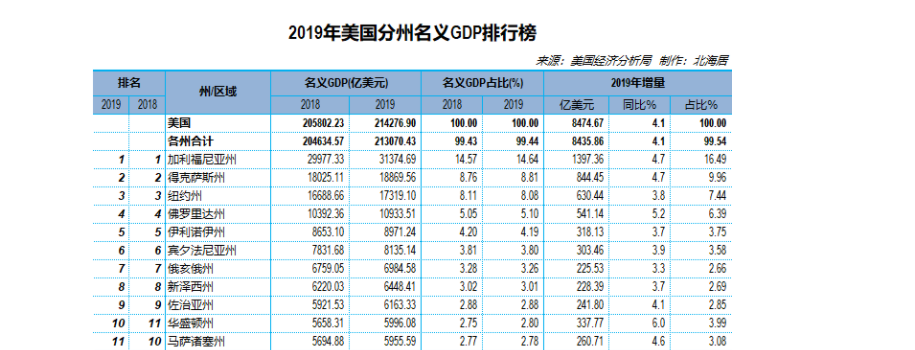

### 4、数据可视化


#### 4.1 按州总捐款数和总捐款人数柱状图

<AxesSubplot:xlabel='STATE'>

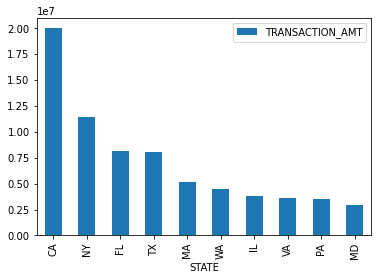

In [26]:
# 各州总捐款数可视化
st_amt = c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False)[:10]
st_amt=pd.DataFrame(st_amt, columns=['TRANSACTION_AMT'])
st_amt.plot(kind='bar')

#### 4.2 各州捐款总人数可视化

<AxesSubplot:xlabel='STATE'>

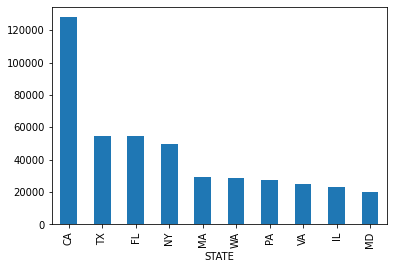

In [27]:
# 各州捐款总人数可视化，取前10个州的数据
st_amt = c_itcont.groupby('STATE').size().sort_values(ascending=False).head(10)
st_amt.plot(kind='bar')

#### 4.3 热门候选人拜登在各州的获得的捐赠占比（前10个州）

array([<AxesSubplot:ylabel='TRANSACTION_AMT'>], dtype=object)

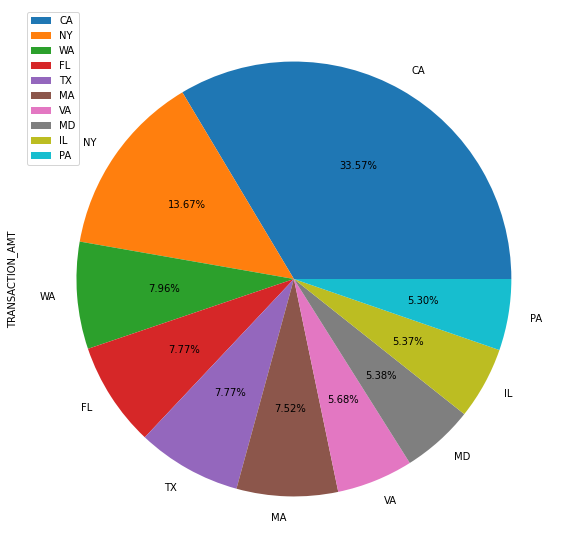

In [28]:
# 从所有数据中取出支持拜登的数据
biden = c_itcont[c_itcont['CAND_NAME']=='BIDEN, JOSEPH R JR']
# 统计各州对拜登的捐款总数
biden_state = biden.groupby('STATE').sum().sort_values("TRANSACTION_AMT", ascending=False).head(10)
# 饼图可视化各州捐款数据占比
biden_state.plot.pie(figsize=(10, 10),autopct='%0.2f%%',subplots=True)

In [28]:
#### 4.3 热门候选人特朗普在各州的获得的捐赠占比（前10个州）

array([<AxesSubplot:ylabel='TRANSACTION_AMT'>], dtype=object)

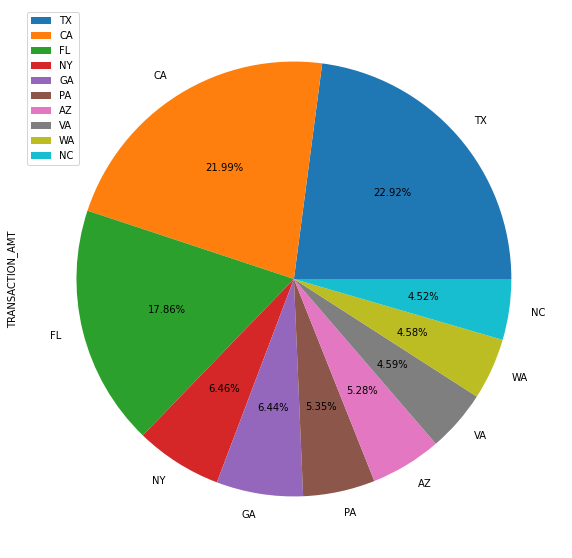

In [29]:
# 从所有数据中取出支持拜登的数据
biden = c_itcont[c_itcont['CAND_NAME']=='TRUMP, DONALD J.']
# 统计各州对拜登的捐款总数
biden_state = biden.groupby('STATE').sum().sort_values("TRANSACTION_AMT", ascending=False).head(10)
# 饼图可视化各州捐款数据占比
biden_state.plot.pie(figsize=(10, 10),autopct='%0.2f%%',subplots=True)

In [30]:
#4.4 各州捐款热力图

Text(0.5, 1.0, 'Total State Contributions')

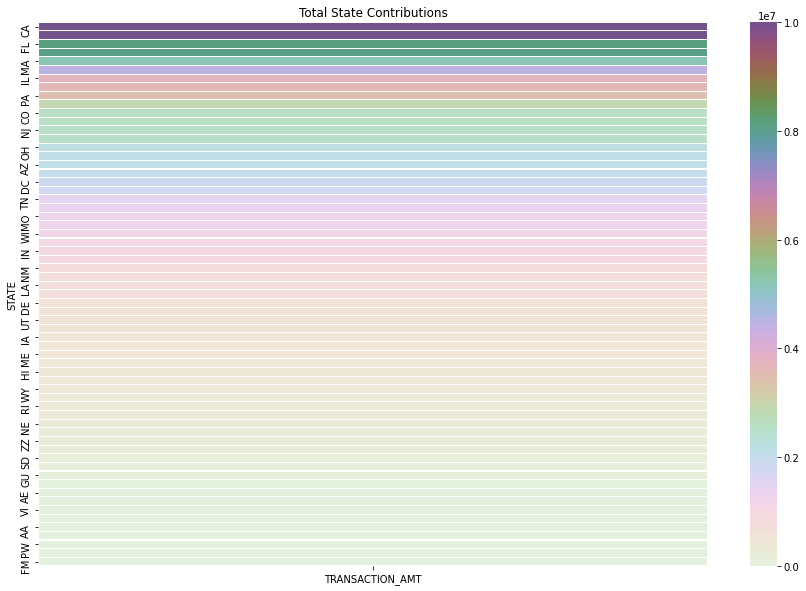

In [30]:
f, ax = plt.subplots(figsize = (15,10))
cmap = sns.cubehelix_palette(start = 1, rot =5, gamma = 0.5, as_cmap = True)
money = c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False)
st_amt1 = pd.DataFrame(money)
sns.heatmap(data = st_amt1, linewidths = 0.05, ax = ax, vmax = 10000000, vmin = 0, cmap = cmap)
ax.set_title('Total State Contributions')

<AxesSubplot:xlabel='None,TRANSACTION_DT'>

<Figure size 720x432 with 0 Axes>

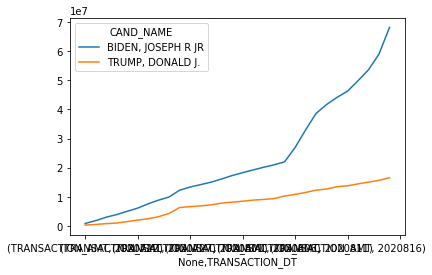

In [31]:
# 收到捐赠额最多的两位候选人的总捐赠额变化趋势(总和)

fig = plt.figure(figsize=(10,6))
c_itcont = pd.DataFrame(c_itcont, columns=[ 'CAND_NAME', 'TRANSACTION_AMT', 'TRANSACTION_DT'])
c_itcont1 = c_itcont[c_itcont['CAND_NAME'].isin(['BIDEN, JOSEPH R JR', 'TRUMP, DONALD J.'])]
c_itcont2 = c_itcont1.groupby(['CAND_NAME', 'TRANSACTION_DT']).sum()
c_itcont3 = c_itcont2.groupby(['CAND_NAME', ]).cumsum()
c_itcont4 = c_itcont3.unstack().T
c_itcont4.plot()

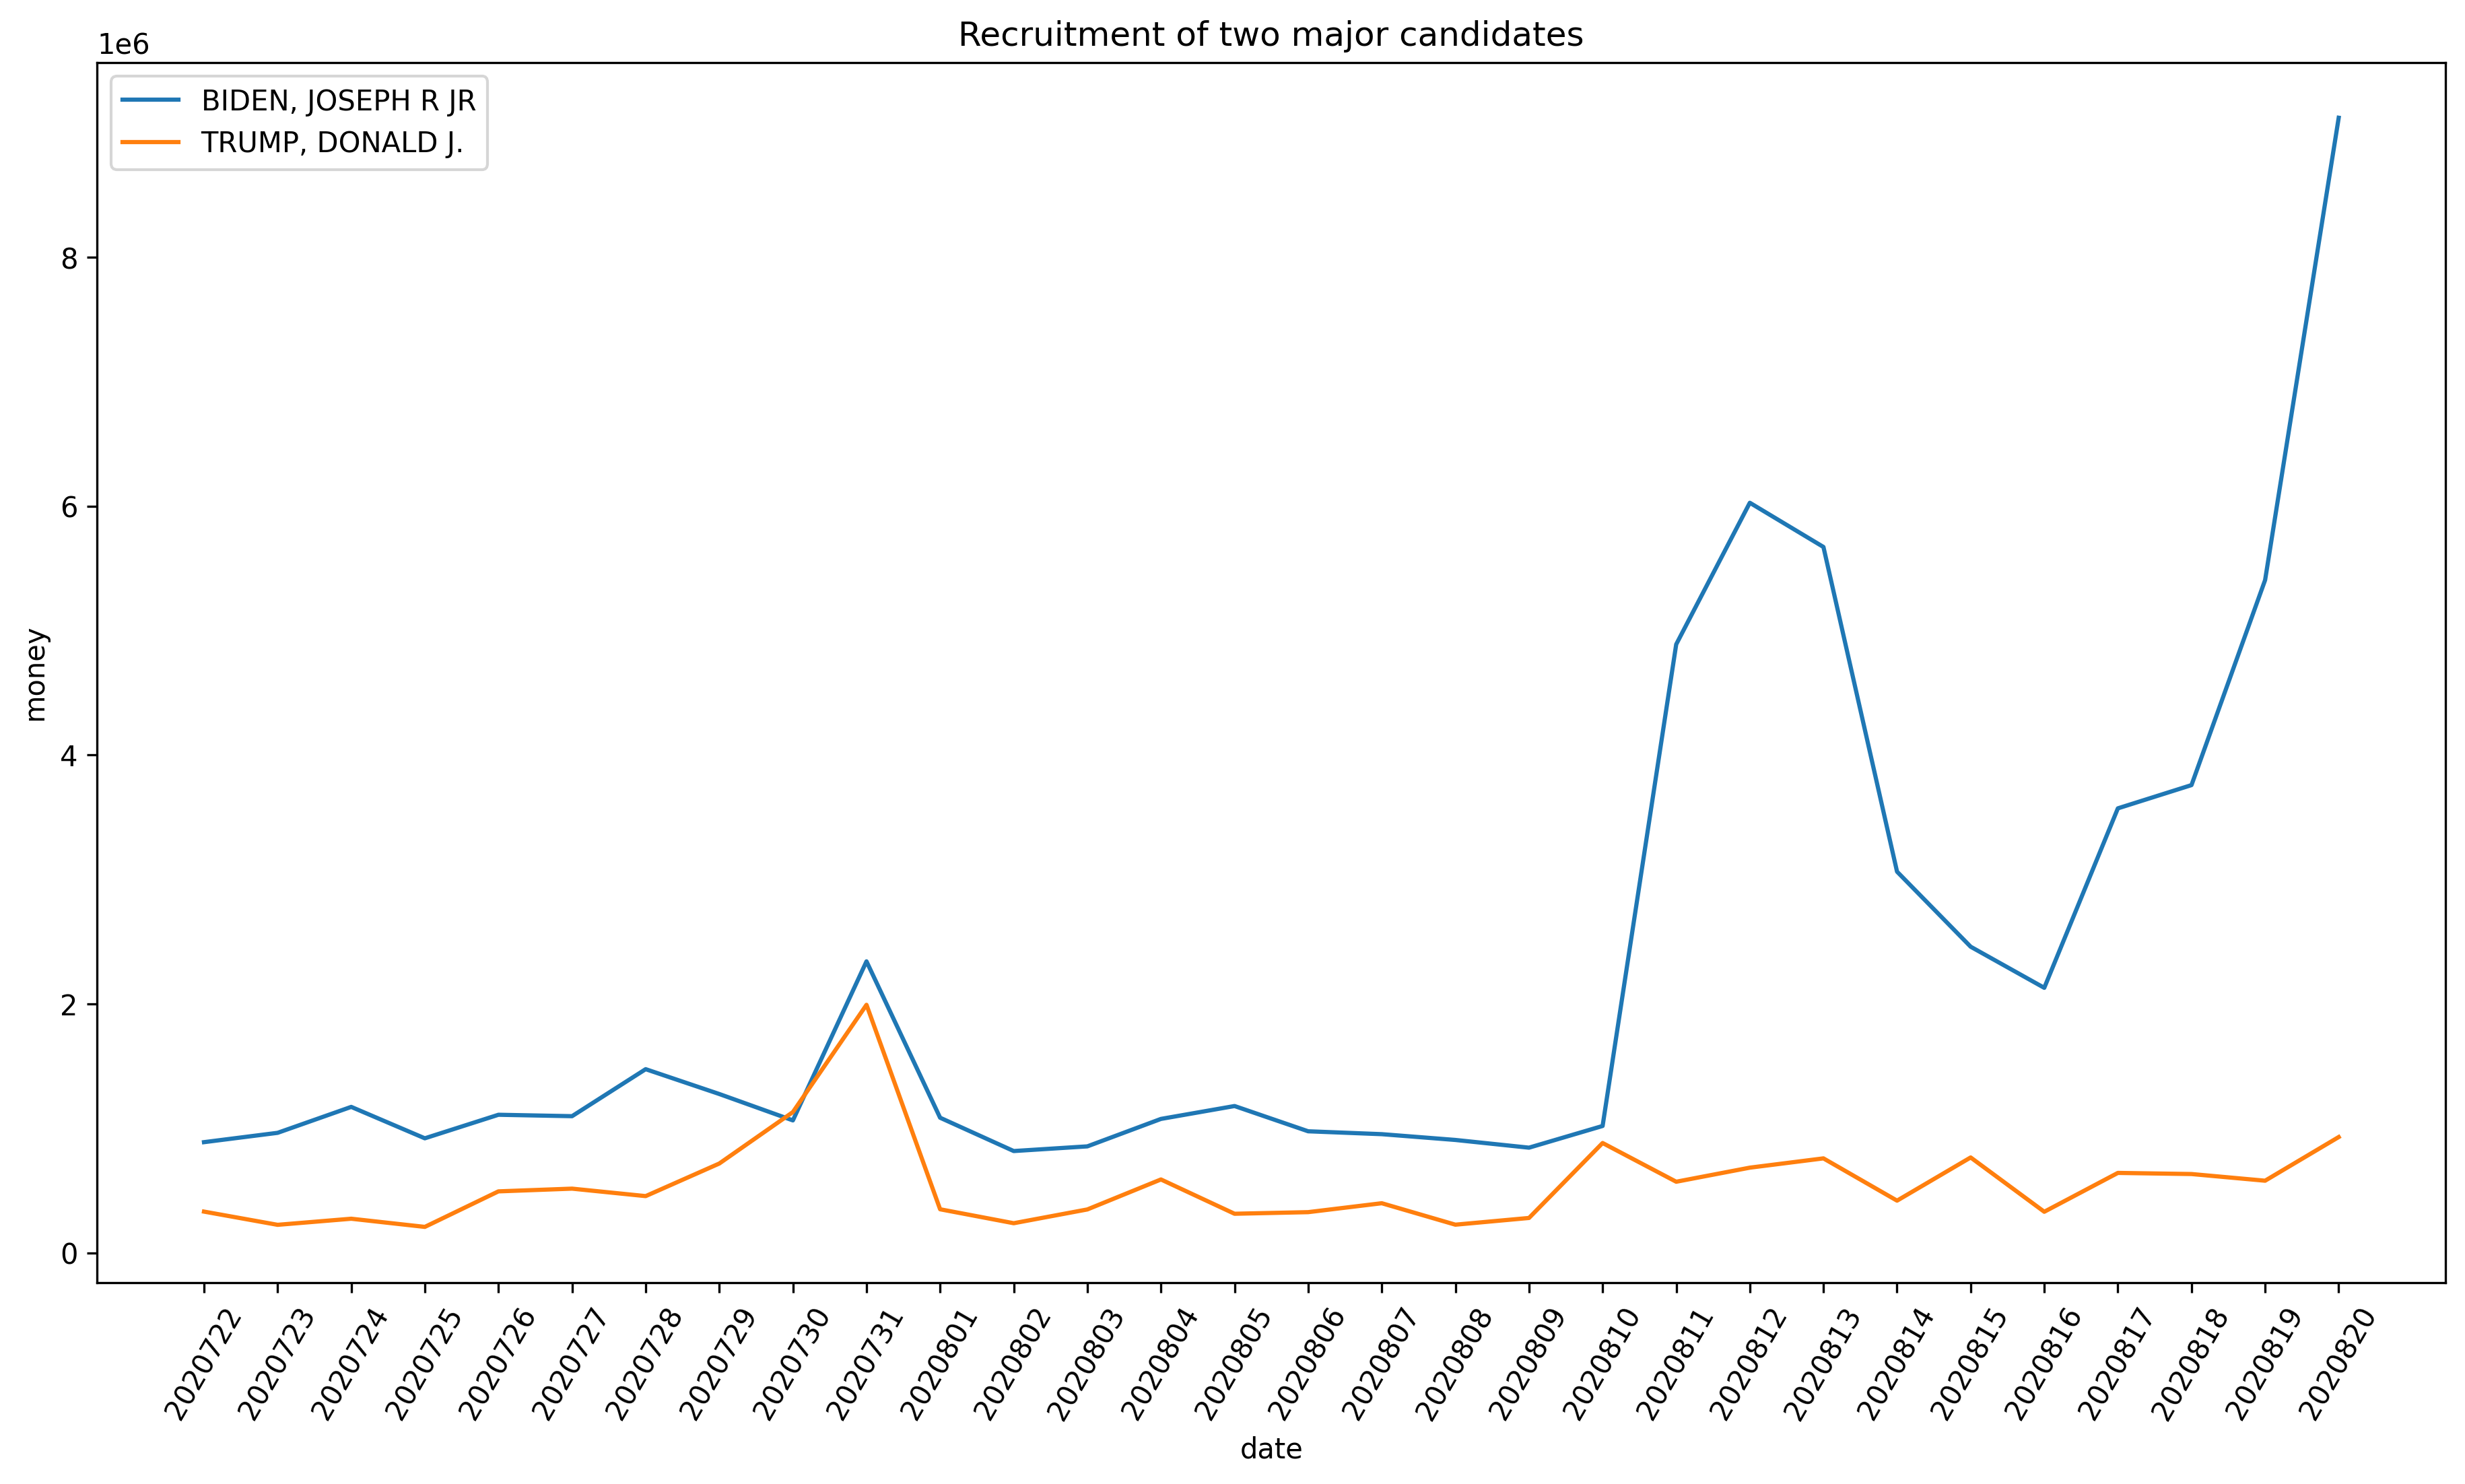

In [32]:
#收到捐赠额最多的两位候选人的总捐赠额变化趋势(分时)
c_bd= c_itcont[c_itcont["CAND_NAME"]=="BIDEN, JOSEPH R JR"].groupby("TRANSACTION_DT").sum()
c_tp=c_itcont[c_itcont["CAND_NAME"]=="TRUMP, DONALD J."].groupby("TRANSACTION_DT").sum()
x = c_bd.index
y1 = c_bd.values
y2 =c_tp.values
plt.figure(figsize=(15,8),dpi=300)
plt.xticks(range(len(x)),x,rotation=60)
plt.xlabel('date')
plt.ylabel('money')
plt.title("Recruitment of two major candidates")
plt.plot(range(len(x)),y1,label="BIDEN, JOSEPH R JR")
plt.plot(range(len(x)),y2,label="TRUMP, DONALD J.")
plt.legend(loc="upper left")
plt.show()

In [ ]:
这里可以看出，拜登在8月份的收获的捐款数额大幅领先特朗普

#### 4.3 总捐最多的候选人捐赠者词云图
通过数据分析中获得捐赠总额前三的候选人统计中可以看出拜登在2020.7.22-2020.8.20这期间获得捐赠的总额是最多的，所以我们以拜登为原模型，制作词云图。

In [34]:

os.rename('TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg', 'biden.jpg')

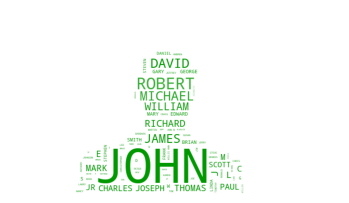

In [35]:
# 在4.2 热门候选人拜登在各州的获得的捐赠占比 中我们已经取出了所有支持拜登的人的数据，存在变量：biden中
# 将所有捐赠者姓名连接成一个字符串
#颜色越深捐款越多
data = ' '.join(biden["NAME"].tolist())
# 读取图片文件
bg = plt.imread("biden.jpg")
# 生成
wc = WordCloud(# FFFAE3
    background_color="white",  # 设置背景为白色，默认为黑色
    width=890,  # 设置图片的宽度
    height=600,  # 设置图片的高度
    mask=bg,    # 画布
    margin=10,  # 设置图片的边缘
    max_font_size=100,  # 显示的最大的字体大小
    random_state=20,  # 为每个单词返回一个PIL颜色
).generate_from_text(data)
# 图片背景
bg_color = ImageColorGenerator(bg)
# 开始画图
plt.imshow(wc.recolor(color_func=bg_color))
# 为云图去掉坐标轴
plt.axis("off")
# 画云图，显示
# 保存云图
wc.to_file("biden_wordcloud.png")

In [ ]:
前面用一个简单的热力图展示，为了更加直观的表达，我们采用了克利夫兰点图、棒棒糖图对该信息进行了表达。

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.


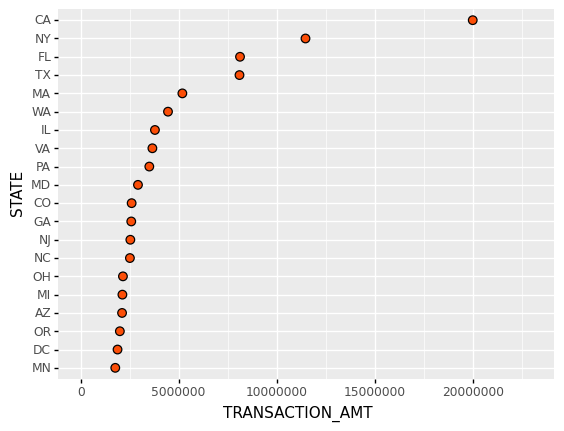

<ggplot: (8784164837524)>


In [38]:
candidates = pd.read_csv("./weball20.txt",sep = '|',names=['CAND_ID','CAND_NAME','CAND_ICI','PTY_CD','CAND_PTY_AFFILIATION','TTL_RECEIPTS',
                                                          'TRANS_FROM_AUTH','TTL_DISB','TRANS_TO_AUTH','COH_BOP','COH_COP','CAND_CONTRIB',
                                                          'CAND_LOANS','OTHER_LOANS','CAND_LOAN_REPAY','OTHER_LOAN_REPAY','DEBTS_OWED_BY',
                                                          'TTL_INDIV_CONTRIB','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT','SPEC_ELECTION','PRIM_ELECTION','RUN_ELECTION'
                                                          ,'GEN_ELECTION','GEN_ELECTION_PRECENT','OTHER_POL_CMTE_CONTRIB','POL_PTY_CONTRIB',
                                                          'CVG_END_DT','INDIV_REFUNDS','CMTE_REFUNDS'])

ccl = pd.read_csv("./ccl.txt", sep = '|',names=['CAND_ID','CAND_ELECTION_YR','FEC_ELECTION_YR','CMTE_ID','CMTE_TP','CMTE_DSGN','LINKAGE_ID'])
ccl = pd.merge(ccl,candidates)
ccl = pd.DataFrame(ccl, columns=[ 'CMTE_ID','CAND_ID', 'CAND_NAME','CAND_PTY_AFFILIATION'])
itcont = pd.read_csv('./itcont_2020_20200722_20200820.txt', sep='|',names=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI', 'IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY',
                                                                                  'STATE','ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT',
                                                                                  'TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
                                                                                  'MEMO_TEXT','SUB_ID'])

c_itcont =  pd.merge(ccl,itcont)
c_itcont = pd.DataFrame(c_itcont, columns=[ 'CAND_NAME','NAME', 'STATE','EMPLOYER','OCCUPATION',
                                           'TRANSACTION_AMT', 'TRANSACTION_DT','CAND_PTY_AFFILIATION'])
#计算、排序
state_amt=c_itcont.groupby('STATE').sum().reset_index(drop=False)
state_amt=state_amt.sort_values(by='TRANSACTION_AMT',ascending=True)[-20:]
state_amt['STATE']=state_amt['STATE'].astype(pd.CategoricalDtype(categories=state_amt['STATE'],ordered=False))
#计算、排序
state_amt=c_itcont.groupby('STATE').sum().reset_index(drop=False)
state_amt=state_amt.sort_values(by='TRANSACTION_AMT',ascending=True)[-20:]
state_amt['STATE']=state_amt['STATE'].astype(pd.CategoricalDtype(categories=state_amt['STATE'],ordered=False))
#克利夫兰点图（Cleveland's Dot Plots） 克利夫兰点图也称滑珠散点图，重点强调数据的排序展示以及互相之间的差距
#克利夫兰点图
base_plot=(ggplot(state_amt,aes('TRANSACTION_AMT','STATE'))+
           geom_point(shape='o',size=3,color='black',fill='#FC4E07')+
           xlim(0,23000000))
print(base_plot)

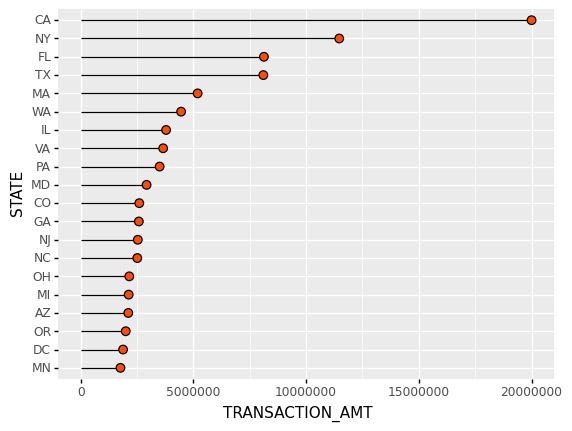

<ggplot: (8784181761544)>


In [40]:
#棒棒糖图（Lollipop Chart） 棒棒糖图传递了跟条形图相似的信息，只是把矩形转换成了线条，看起来更加简洁美观，相比条形图，棒棒糖图更适用数据量较多的情况。
#棒棒糖图
base_plot=(ggplot(state_amt,aes('TRANSACTION_AMT','STATE'))+
           geom_segment(aes(x=0,xend='TRANSACTION_AMT',y='STATE',yend='STATE'))+
           geom_point(shape='o',size=3,color='black',fill='#FC4E07')
           )
print(base_plot)

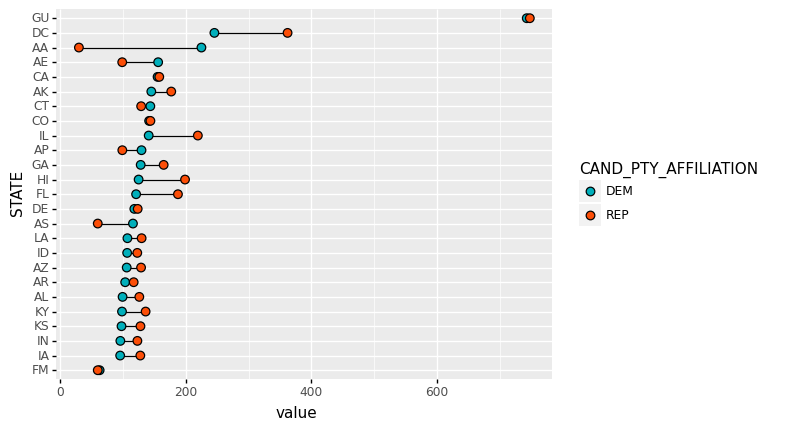

<ggplot: (-9223363252673013728)>


In [41]:
#哑铃图（Dumbbell Plot） 哑铃图是多数据系列的克利夫兰点图，用直线连接两个数据系列。主要用于： 1.展示在同一时间段两个数据点的相对位置（增加或者减少）； 2.比较两个类别之间的数据值差别。
#哑铃图，随便选取了20个州，对比民主党和共和党在该州得到的人均捐赠额。
df_party=c_itcont[['STATE','TRANSACTION_AMT','CAND_PTY_AFFILIATION']]
df_party=df_party[df_party.CAND_PTY_AFFILIATION.isin(['REP','DEM'])]
df_pivot=df_party.pivot_table(index='STATE',columns='CAND_PTY_AFFILIATION',values='TRANSACTION_AMT',aggfunc=np.mean)
re_pivot=df_pivot.reset_index(drop=False)[:25].sort_values(by='DEM',ascending=True)
re_pivot['REP'].fillna(60,inplace=True)
re_pivot['STATE']=re_pivot['STATE'].astype(pd.CategoricalDtype(categories=re_pivot['STATE'],ordered=True))
mydata=pd.melt(re_pivot,id_vars='STATE')

base_plot=(ggplot(mydata,aes('value','STATE',fill='CAND_PTY_AFFILIATION'))+
           geom_line(aes(group='STATE'))+
           geom_point(shape='o',size=3,color='black')+
           scale_fill_manual(values=('#00AFBB','#FC4E07','#36BED9')))
print(base_plot)

In [43]:
# 按州总捐款热力地图
'''
参赛选手自由发挥、补充
第一个补充热力地图的参赛选手可以获得天池杯子一个
'''
from pyecharts.datasets import register_url
from pyecharts.charts import Geo
from pyecharts.globals import ChartType
from pyecharts import options as opts
def draw_usa_map1():
    states = list(c_itcont['STATE'].value_counts().index)
    num = list(c_itcont['STATE'].value_counts())
    print(states, num)
    # states = ['CA', 'TX', 'FL', 'NY', 'MA', 'WA', 'PA', 'VA', 'IL', 'MD', 'NJ', 'NC', 'AZ', 'CO', 'MI', 'GA', 'OH', 'OR', 'MN', 'TN', 'CT', 'MO', 'IN', 'SC', 'WI', 'DC', 'NV', 'OK', 'NM', 'AL', 'LA', 'NH', 'KY', 'DE', 'KS', 'UT', 'IA', 'AR', 'ID', 'ME', 'MS', 'AK', 'HI', 'NE', 'MT', 'RI', 'VT', 'WV', 'WY', 'SD', 'ND', 'ZZ', 'AE', 'PR', 'VI', 'GU', 'AP', 'NOT PROVIDED', 'AA', 'MP', 'PW', 'AS', 'FM']
    # num = [127895, 54457, 54343, 49453, 29314, 28663, 27670, 24913, 23391, 20307, 20180, 19145, 18253, 18237, 18085, 18078, 17833, 14731, 11938, 10603, 9939, 9321, 8920, 8705, 7928, 7476, 7227, 6405, 6220, 6209, 5908, 5584, 5114, 4912, 4744, 4678, 4481, 3883, 3508, 3187, 2861, 2812, 2781, 2610, 2405, 2349, 1901, 1837, 1245, 1214, 884, 776, 199, 158, 103, 86, 60, 45, 22, 10, 6, 2, 1]
    all = ['WA', 'OR', 'CA', 'AK', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'HI', 'CO', 'NM', 'ND', 'SD', 'NE', 'KS', 'OK',
           'TX', 'MN', 'IA', 'MO', 'AR', 'LA', 'WI', 'MI', 'IL', 'IN', 'OH', 'KY', 'TN', 'MS', 'AL', 'FL', 'GA', 'SC',
           'NC', 'VA', 'WV', 'PA', 'NY', 'MD', 'DE', 'NJ', 'VT', 'NH', 'MA', 'CT', 'RI', 'ME', 'PR', 'DC']
    count = 0
    index_to_delete = []
    for i in states:
        if i not in all:
            index_to_delete.append(count)
        count += 1
    list1 = [states[i] for i in range(0, len(states), 1) if i not in index_to_delete]  # 删除后的列表
    list2 = [num[i] for i in range(0, len(num), 1) if i not in index_to_delete]

    try:
        register_url("https://echarts-maps.github.io/echarts-countries-js/")
    except Exception:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        register_url("https://echarts-maps.github.io/echarts-countries-js/")

    list21 = [[list1[i], list2[i]]
              for i in range(len(list1))]  # 合并两个list为一个list

    geo = (  # 添加坐标点
        Geo(init_opts=opts.InitOpts(width="1200px",
                                    height="600px", bg_color='#EEEEE8'))
        .add_schema(maptype="美国", itemstyle_opts=opts.ItemStyleOpts(color="#323c48", border_color="#111"))
        .add_coordinate('WA', -120.04, 47.56)
        .add_coordinate('OR', -120.37, 43.77)
        .add_coordinate('CA', -120.44, 36.44)
        .add_coordinate('AK', -122.00, 28.46)
        .add_coordinate('ID', -114.08, 43.80)
        .add_coordinate('NV', -116.44, 39.61)
        .add_coordinate('MT', -109.42, 47.13)
        .add_coordinate('WY', -107.29, 42.96)
        .add_coordinate('UT', -111.19, 39.35)
        .add_coordinate('AZ', -111.70, 34.45)
        .add_coordinate('HI', -105.25, 28.72)
        .add_coordinate('CO', -105.52, 38.89)
        .add_coordinate('NM', -106.11, 34.45)
        .add_coordinate('ND', -100.22, 47.53)
        .add_coordinate('SD', -100.52, 44.72)
        .add_coordinate('NE', -99.64, 41.65)
        .add_coordinate('KS', -98.53, 38.43)
        .add_coordinate('OK', -97.13, 35.42)
        .add_coordinate('TX', -98.16, 31.03)
        .add_coordinate('MN', -94.26, 46.02)
        .add_coordinate('IA', -93.60, 42.09)
        .add_coordinate('MO', -92.57, 38.48)
        .add_coordinate('AR', -92.43, 34.69)
        .add_coordinate('LA', -92.49, 31.22)
        .add_coordinate('WI', -89.55, 44.25)
        .add_coordinate('MI', -84.62, 43.98)
        .add_coordinate('IL', -89.11, 40.20)
        .add_coordinate('IN', -86.17, 40.08)
        .add_coordinate('OH', -82.71, 40.31)
        .add_coordinate('KY', -84.92, 37.44)
        .add_coordinate('TN', -86.32, 35.78)
        .add_coordinate('MS', -89.63, 32.66)
        .add_coordinate('AL', -86.68, 32.53)
        .add_coordinate('FL', -81.68, 28.07)
        .add_coordinate('GA', -83.22, 32.59)
        .add_coordinate('SC', -80.65, 33.78)
        .add_coordinate('NC', -78.88, 35.48)
        .add_coordinate('VA', -78.24, 37.48)
        .add_coordinate('WV', -80.63, 38.62)
        .add_coordinate('PA', -77.57, 40.78)
        .add_coordinate('NY', -75.22, 43.06)
        .add_coordinate('MD', -76.29, 39.09)
        .add_coordinate('DE', -75.55, 39.09)
        .add_coordinate('NJ', -74.47, 40.03)
        .add_coordinate('VT', -72.70, 44.13)
        .add_coordinate('NH', -71.64, 43.59)
        .add_coordinate('MA', -72.09, 42.33)
        .add_coordinate('CT', -72.63, 41.67)
        .add_coordinate('RI', -71.49, 41.64)
        .add_coordinate('ME', -69.06, 45.16)
        .add_coordinate('PR', -75.37, 26.42)
        .add_coordinate('DC', -77.04, 38.90)
        .add("num", list21,type_=ChartType.HEATMAP)
        .set_global_opts(
            title_opts=opts.TitleOpts(title="美国选举捐款数"),
            visualmap_opts=opts.VisualMapOpts(max_=10000, is_piecewise=False),
        ).render("tianchi_heatmap.html")
    )


draw_usa_map1()

['CA', 'TX', 'FL', 'NY', 'MA', 'WA', 'PA', 'VA', 'IL', 'MD', 'NJ', 'NC', 'AZ', 'CO', 'MI', 'GA', 'OH', 'OR', 'MN', 'TN', 'CT', 'MO', 'IN', 'SC', 'WI', 'DC', 'NV', 'OK', 'NM', 'AL', 'LA', 'NH', 'KY', 'DE', 'KS', 'UT', 'IA', 'AR', 'ID', 'ME', 'MS', 'AK', 'HI', 'NE', 'MT', 'RI', 'VT', 'WV', 'WY', 'SD', 'ND', 'ZZ', 'AE', 'PR', 'VI', 'GU', 'AP', 'AA', 'MP', 'PW', 'AS', 'FM'] [127895, 54457, 54343, 49453, 29314, 28663, 27670, 24913, 23391, 20307, 20180, 19145, 18253, 18237, 18085, 18078, 17833, 14731, 11938, 10603, 9939, 9321, 8920, 8705, 7928, 7476, 7227, 6405, 6220, 6209, 5908, 5584, 5114, 4912, 4744, 4678, 4481, 3883, 3508, 3187, 2861, 2812, 2781, 2610, 2405, 2349, 1901, 1837, 1245, 1214, 884, 776, 199, 158, 103, 86, 60, 22, 10, 6, 2, 1]


In [44]:
c_itcont.loc[c_itcont['STATE']=='NOT PROVIDED','STATE']= 'NP'
# 为各州创建数值
a = list(set(list(c_itcont[['STATE']].values[:,0])))
dic = dict(enumerate(a))
dic = dict([(v,k) for k, v in dic.items()])
# 为各州赋予数值
c_itcont['STATE_NUM'] = c_itcont['STATE'].apply(lambda x:dic[x])
# 为各个时间点创建数值
b = list(set(list(c_itcont[['TRANSACTION_DT']].values[:,0])))
b.sort(reverse=False)
dic1 = dict(enumerate(b))
dic1 = dict([(v,k) for k, v in dic1.items()])
#为时间点赋予数值
c_itcont['DATE_NUM'] = c_itcont['TRANSACTION_DT'].apply(lambda x:dic1[x])
import numpy as np
# 将数值的int转化为str并创建唯一ID
c_itcont['DATE_NUM'] = c_itcont['DATE_NUM'].apply(str)
c_itcont['STATE_NUM'] = c_itcont['STATE_NUM'].apply(str)
c_itcont['combined_id'] = c_itcont['DATE_NUM']+c_itcont['STATE_NUM']
c_itcont['combined_id'] = pd.factorize(c_itcont.STATE_NUM+c_itcont.DATE_NUM)[0]
# 以唯一ID进行分组求和
sum = c_itcont.groupby('combined_id')['TRANSACTION_AMT'].sum()
sum = pd.DataFrame(sum)
c_itcont.drop_duplicates(subset=['combined_id'], keep='first', inplace=True)
# 连接表
c_itcont = pd.merge(c_itcont, sum, how='left',on='combined_id')
# 将数值的str类型转化为int类型以传入坐标
c_itcont['STATE_NUM'] = c_itcont['STATE_NUM'].apply(int)
c_itcont['DATE_NUM'] = c_itcont['DATE_NUM'].apply(int)
data_list = []
# 开始制作坐标集，其中去除极少数z轴为负值的坐标
x = list(c_itcont['STATE_NUM'])
y = list(c_itcont['DATE_NUM'])
z = list(c_itcont['TRANSACTION_AMT_y'])
for i in range(0, len(c_itcont['STATE_NUM'])):
    if z[i] < 0:
        continue
    data = x[i], y[i], z[i]
    data_list.append(data)
# 以数字顺序准备州与日期的标签
state_key = list(dic.keys())
date_key = list(dic1.keys())    
# 对坐标集排序
data_list_sorted = sorted(data_list)
from pyecharts.charts import Bar3D
# 绘制3D柱状图，并保存到'3D_STATE_AMT.html'
"""
缩放/旋转不同角度可以观察到美国民众的捐款规律
"""
c = (
        Bar3D(init_opts=opts.InitOpts(bg_color='rgba(255,250,205,0.2)',width="1400px",
                                    height="800px")).add(
            "",
            data_list_sorted,
            xaxis3d_opts=opts.Axis3DOpts(state_key,
                 type_="category", interval=0),
            yaxis3d_opts=opts.Axis3DOpts(date_key,
                type_="category", interval=1),
            zaxis3d_opts=opts.Axis3DOpts(type_="value"),
            grid3d_opts=opts.Grid3DOpts(width=340, height=180, depth=200,is_rotate=False))
        .set_global_opts(
            visualmap_opts=opts.VisualMapOpts(max_=max(z)),
            title_opts=opts.TitleOpts(title="各州捐款3D柱状图"),
        ).render("3D_STATE_AMT.html")
    )

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


,sum_sq,df,F,PR(>F)
num,9.871919e+05,1.0,26.143431,0.000001
Residual,4.682316e+06,124.0,NaN,NaN


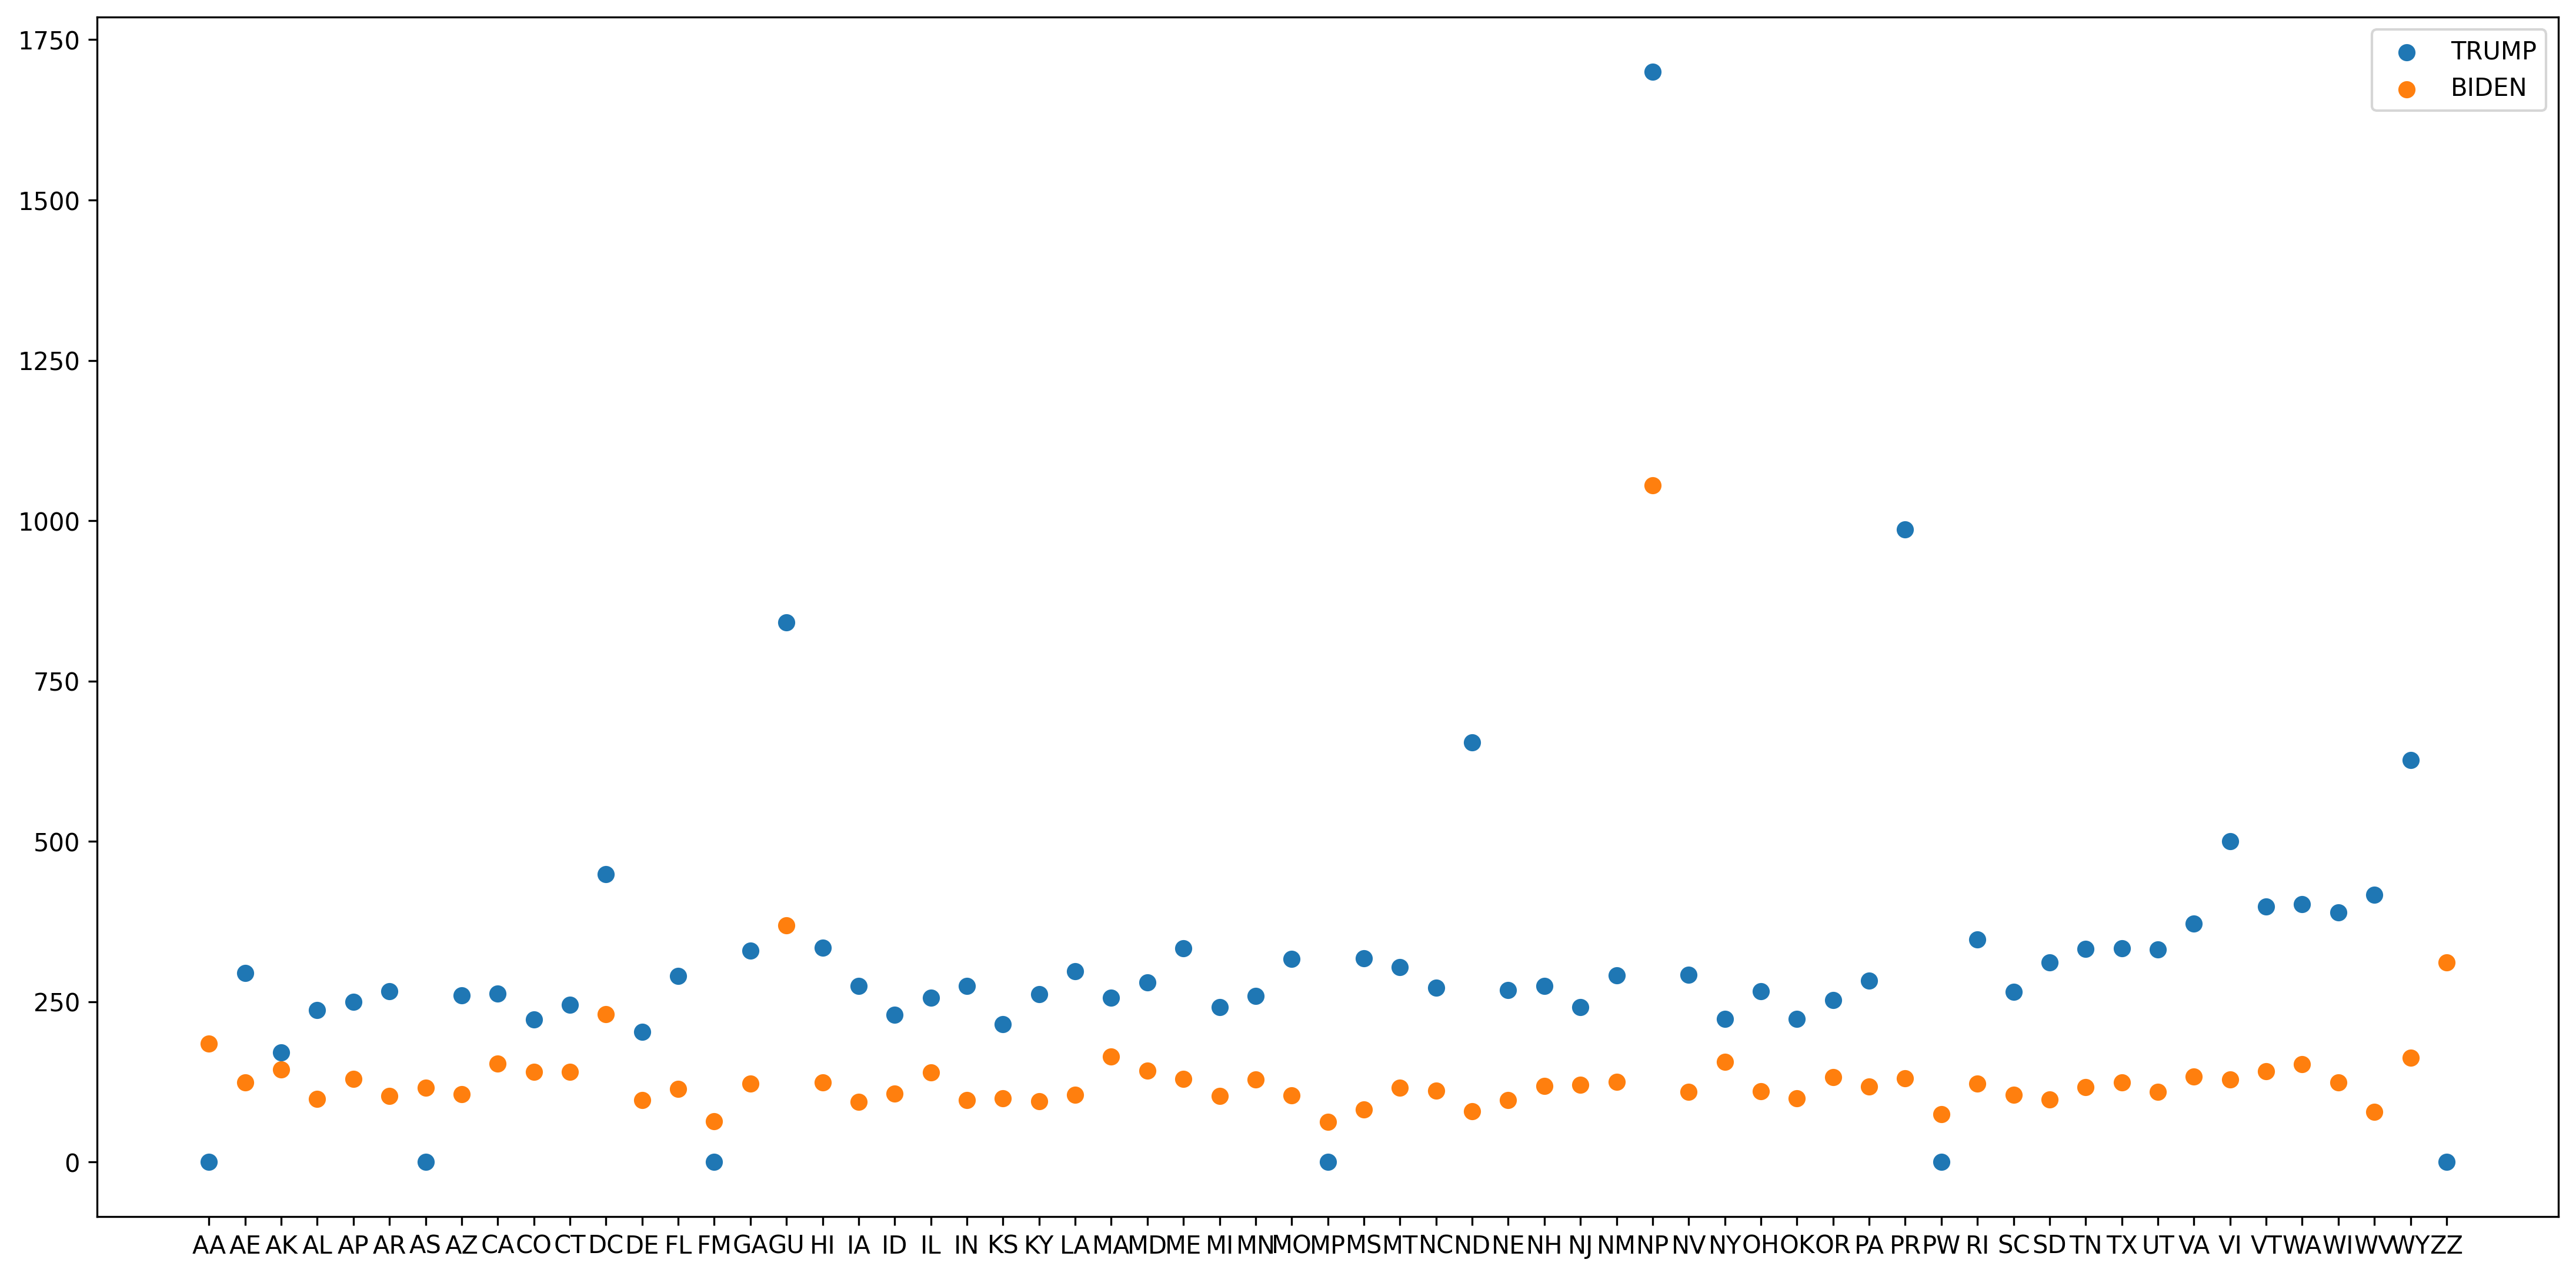

In [16]:
c_itcont.loc[c_itcont['STATE'] == 'NOT PROVIDED', 'STATE'] = 'NP'# NOT PROVIDE缩写为NP，以展示更好的显示效果
BIDEN = c_itcont[c_itcont['CAND_NAME'] == 'BIDEN, JOSEPH R JR']# 提取候选人为拜登的数据
BIDEN_table = pd.DataFrame(BIDEN.groupby('STATE').mean())# 对拜登以州分组求捐款额的平均数
TRUMP = c_itcont[c_itcont['CAND_NAME'] == 'TRUMP, DONALD J.']# 提取候选人为特朗普的数据
TRUMP_table = pd.DataFrame(TRUMP.groupby('STATE').mean())# 对特朗普以州分组求捐款额的平均数
combined_table = pd.merge(BIDEN_table, TRUMP_table, how='left', on='STATE')# 以州为索引组合两表
combined_table = combined_table.fillna(0)# 补全捐款额为空的州
combined_table.columns = ['BIDEN', 'TRUMP']# 重命名两列
"""
绘制两候选人各州人均捐款额的散点图
"""
fig = plt.figure(figsize=(18,9), dpi=300)
plt.scatter(list(combined_table.index),list(combined_table['TRUMP']),label='TRUMP')
plt.scatter(list(combined_table.index),list(combined_table['BIDEN']),label='BIDEN')
plt.legend()
"""
方差分析
"""
!pip install statsmodels --user
import statsmodels.api as sm
from statsmodels.formula.api import ols
num = sorted(['TRUMP', 'BIDEN']*63)
data =list(combined_table['TRUMP'])+list(combined_table['BIDEN'])
df = pd.DataFrame({'num':num, 'data': data})
mod = ols('data ~ num', data=df).fit()
ano_table = sm.stats.anova_lm(mod, typ=2)
ano_table